In [1]:
%matplotlib inline
import os
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

In [3]:
d2l.DATA_HUB['hotdog'] = (d2l.DATA_URL + 'hotdog.zip', 'fba480ffa8aa7e0febbb511d181409f899b9baa5')
data_dir = d2l.download_extract('hotdog')
train_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'train'))
test_imgs = torchvision.datasets.ImageFolder(os.path.join(data_dir, 'test'))

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

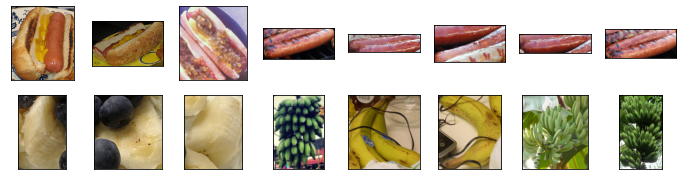

In [4]:
hotdogs = [train_imgs[i][0] for i in range(8)]
not_hotdogs = [train_imgs[-i-1][0] for i in range(8)]
d2l.show_images(hotdogs+not_hotdogs, 2, 8, scale=1.5)

# Normalization+Augmentation

In [10]:
# normalize mean and variance--just to fit the normalization in ImageNet
normalize = torchvision.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

train_augs = torchvision.transforms.Compose([
    torchvision.transforms.transforms.RandomResizedCrop(224), # resize img to 224x224
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])
test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

# Get pretrained model from torchvision

In [17]:
# get model, resnet18 and its parameters
pretrained_net = torchvision.models.resnet18(pretrained=True)
'''
pth downloaded in /Users/liwuchen/.cache/torch/hub/checkpoints
if you get a bug report, clear cache and retry
'''
# get fully connected layer
pretrained_net.fc

Linear(in_features=512, out_features=1000, bias=True)

# Fine tune--modify pretrained net

In [18]:
finetune_net = torchvision.models.resnet18(pretrained=True)
# modify the last layer--outputsize=2
finetune_net.fc = nn.Linear(finetune_net.fc.in_features, 2)
nn.init.xavier_uniform_(finetune_net.fc.weight)

Parameter containing:
tensor([[ 0.0002,  0.0670, -0.0276,  ..., -0.1077,  0.0471,  0.0019],
        [-0.0390,  0.0657,  0.0574,  ..., -0.0733,  0.0909,  0.0957]],
       requires_grad=True)

In [19]:
def train_fine_tuning(net, learning_rate, batch_size=128, num_epochs=5,
                      param_group=True):
    train_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train'), transform=train_augs),
        batch_size=batch_size, shuffle=True)
    test_iter = torch.utils.data.DataLoader(torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'test'), transform=test_augs),
        batch_size=batch_size)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss(reduction="none")
    # param_group=True, assign a greater learning rate(10x) to the last layer(cause the last layer is not pretrained)
    if param_group:
        params_1x = [param for name, param in net.named_parameters()
             if name not in ["fc.weight", "fc.bias"]]
        trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.fc.parameters(),
                                    'lr': learning_rate * 10}], # 10x learning rate to fc layer
                                lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, test_iter, loss, trainer, num_epochs,
                   devices)

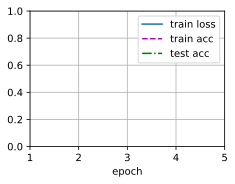

In [ ]:
train_fine_tuning(finetune_net, 5e-5)

### without pretrain

In [ ]:
scratch_net = torchvision.models.resnet18(pretrained=False)
scratch_net
train_fine_tuning(finetune_net, 5e-5)